In [ ]:
!pip install -q uncertainty-calibration

  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import pandas as pd
import torch
import random
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
import calibration as cal
from torch.nn import functional as F
import scipy

from matplotlib import style
import pathlib
from sklearn.linear_model import LogisticRegression
plt.style.use('seaborn-v0_8')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def get_ece_em(probs, labels, p=1, debias=False, num_bins=15, mode='top-label'):
    """Get ECE, but use equal mass binning."""
    return cal.lower_bound_scaling_ce(probs, labels, p=p, debias=debias, num_bins=num_bins,
                                  binning_scheme=cal.get_equal_bins, mode=mode)


In [ ]:
def run_exp(args):

    # print(args)

    save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/output/{}/{}/".format(args.model, args.dataset)
    os.makedirs(save_path, exist_ok=True)

    all_features = np.load(save_path+"features.npy")
    all_logits = np.load(save_path+"logits.npy")
    all_labels = np.load(save_path+"labels.npy")

    props = [i/10 for i in range(11)]


    rows = []

    for alpha in props:

        n_linear = int(alpha*args.n_val)
        n_recal = args.n_val - n_linear

        if alpha == 0.0:
            args.linear = False
        else:
            args.linear = True

        if alpha == 1.0:
            args.recal = False
        else:
            args.recal = True

        for trial_no in range(args.n_trials):

            try:

                # split data
                rand_inds = np.random.permutation(all_features.shape[0])

                f_val = all_features[rand_inds[:args.n_val]]
                z_val = all_logits[rand_inds[:args.n_val]]
                y_val = all_labels[rand_inds[:args.n_val]]

                f_test = all_features[rand_inds[args.n_val:]]
                z_test = all_logits[rand_inds[args.n_val:]]
                y_test = all_labels[rand_inds[args.n_val:]]

                val_acc = np.sum(np.argmax(z_val, -1) == y_val)/y_val.shape[0]
                test_acc = np.sum(np.argmax(z_test, -1) == y_test)/y_test.shape[0]


                def softmax(x):
                    """Compute softmax values for each sets of scores in x."""
                    e_x = np.exp(x - np.max(x))
                    return e_x / e_x.sum(axis=1)

                if args.linear:
                    # print("fitting regression...")

                    g = LogisticRegression(random_state=0).fit(f_val[:n_linear], y_val[:n_linear])
                    if args.recal:
                        c_val = g.predict_proba(f_val[n_linear:])
                else:
                    c_val = scipy.special.softmax(z_val, axis=-1)

                if args.recal:

                    # train recalibrator h
                    if args.cal_fn == "platt":
                        h = cal.PlattCalibrator(n_recal, num_bins=10)
                        a_labels = (np.argmax(c_val, -1) == y_val[n_linear:])*1
                        # print("a_labrels", a_labels.shape, a_labels.sum())
                        h.train_calibration(np.max(c_val, -1), a_labels)
                    elif args.cal_fn == "hist":
                        h = cal.HistogramCalibrator(n_recal, num_bins=10)
                        a_labels = (np.argmax(c_val, -1) == y_val[n_linear:])*1
                        h.train_calibration(np.max(c_val, -1), a_labels)
                    elif args.cal_fn == "platt_bin":
                        h = cal.PlattBinnerCalibrator(n_recal, num_bins=10)
                        a_labels = (np.argmax(c_val, -1) == y_val[n_linear:])*1
                        h.train_calibration(np.max(c_val, -1), a_labels)

                # get test probs from g
                if args.linear:
                    # apply clf to test data, get probs
                    c_test = g.predict_proba(f_test)
                else:
                    # apply softmax to test logits to get probs
                    c_test = scipy.special.softmax(z_test, axis=-1)

                final_test_acc = np.sum(np.argmax(c_test, -1) == y_test)/y_test.shape[0]
                test_item_acc = (np.argmax(c_test, -1) == y_test)*1

                c_test = np.max(c_test, -1)
                if args.recal:
                    c_test = h.calibrate(c_test)


                # # calculcate calibration metrics
                ece1 = get_ece_em(c_test, test_item_acc, p=1)
                ece2 = get_ece_em(c_test, test_item_acc, p=2)

                # # save results row

                row = [
                    args.dataset,
                    args.model,
                    args.cal_fn,
                    args.n_val,
                    trial_no,
                    alpha,
                    ece1,
                    ece2,
                    final_test_acc,
                ]


                rows.append(row)
            except Exception as e:

                continue

    # make df
    df = pd.DataFrame(rows, columns=["dataset", "model", "cal_fn", "n_val", "trial_no", "alpha", "ece1", "ece2", "acc"])
    return df


In [ ]:
@dataclass
class Args:
    dataset: str
    model: str="quilt"
    seed: int=0
    n_val: int=1000
    n_trials: int=1
    cal_fn: str="platt"

In [ ]:
models = [
    "plip",
    "biomed",
    "quilt",
]

model_map = {
    "plip": "PLIP",
    "biomed": "BioMed",
    "quilt": "QuiltNet",
}

datasets = [
    "databiox",
    "sicap",
    "renal_cell",
    "bach",
    "osteo",
    "nck",
    "skin_tumor",
    "skin",
    "pcam",
    "mhist",
    "lc25000_lung",
    "lc25000_colon",
]

dataset_map = {
    "databiox": "Databiox",
    "sicap": "SICAP",
    "renal_cell": "RenalCell",
    "bach": "BACH",
    "osteo": "Osteo",
    "nck": "NCK-CRC",
    "skin_tumor": "Skin Tumor",
    "skin": "Skin Cancer",
    "pcam": "PCam",
    "lc25000_lung": "LC-Lung",
    "lc25000_colon": "LC-Colon",
    "mhist": "MHIST"
}


In [ ]:
dfs = []

cal_fns = [
    "platt",
    "hist",
    "platt_bin"
]

n_vals = [
    250,
    500,
    1000,
    2000
]

n_trials = 10
for n_val in tqdm(n_vals):
    for model in tqdm(models, leave=False):
        for dataset in tqdm(datasets, leave=False):
            for cal_fn in cal_fns:
                # print("----")
                args = Args(dataset = dataset, model=model, cal_fn=cal_fn, n_trials=n_trials, n_val=n_val)
                df = run_exp(args)

                # display(df)
                dfs.append(df)

        final_df = pd.concat(dfs)
        # display(final_df)

In [ ]:
# SAVE FINAL DF (with timestamp)
from datetime import datetime

now = datetime.now() # current date and time
date_time = now.strftime("%m-%d-%Y_%H-%M-%S")
df_save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/output/few_shot_exp/final_df_{}.csv".format(date_time)
final_df.to_csv(df_save_path, index=False)


In [ ]:
df_save_path

'drive/MyDrive/CV2_project/code/med_vlm_cal/output/few_shot_exp/final_df_04-07-2024_15-49-51.csv'

In [ ]:
pd.read_csv("final_df_04-04-2024_15-42-57.csv")

<ipython-input-21-fcd209e1d26c>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Greys')


,ece1,ece2,acc
alpha,,,
0.0,0.033786,0.042090,0.579718
0.1,0.032218,0.042154,0.633465
0.2,0.028136,0.037844,0.707392
0.3,0.027455,0.037192,0.742225
0.4,0.027229,0.037573,0.768816
0.5,0.027762,0.038202,0.785623
0.6,0.029401,0.040738,0.798923
0.7,0.032750,0.045223,0.809119
0.8,0.037302,0.051502,0.817937


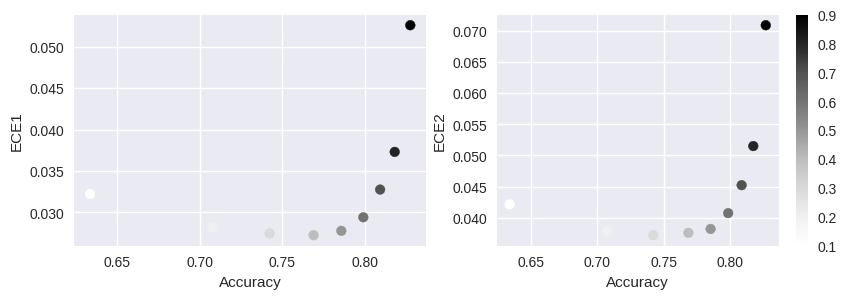

In [ ]:
plt.rcParams["figure.figsize"] = (10,3)
fig, axs = plt.subplots(1,2)
cm = plt.cm.get_cmap('Greys')

alphas = [i/10 for i in range(11)]

grouped = final_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
display(grouped)
axs[0].scatter(grouped["acc"].tolist()[1:10], grouped["ece1"].tolist()[1:10], c=alphas[1:10], cmap=cm)
axs[0].set_xlabel("Accuracy")
axs[0].set_ylabel("ECE1")

sc = axs[1].scatter(grouped["acc"].tolist()[1:10], grouped["ece2"].tolist()[1:10], c=alphas[1:10], cmap=cm)
axs[1].set_xlabel("Accuracy")
axs[1].set_ylabel("ECE2")

plt.colorbar(sc)
plt.show()

plip
biomed
quilt


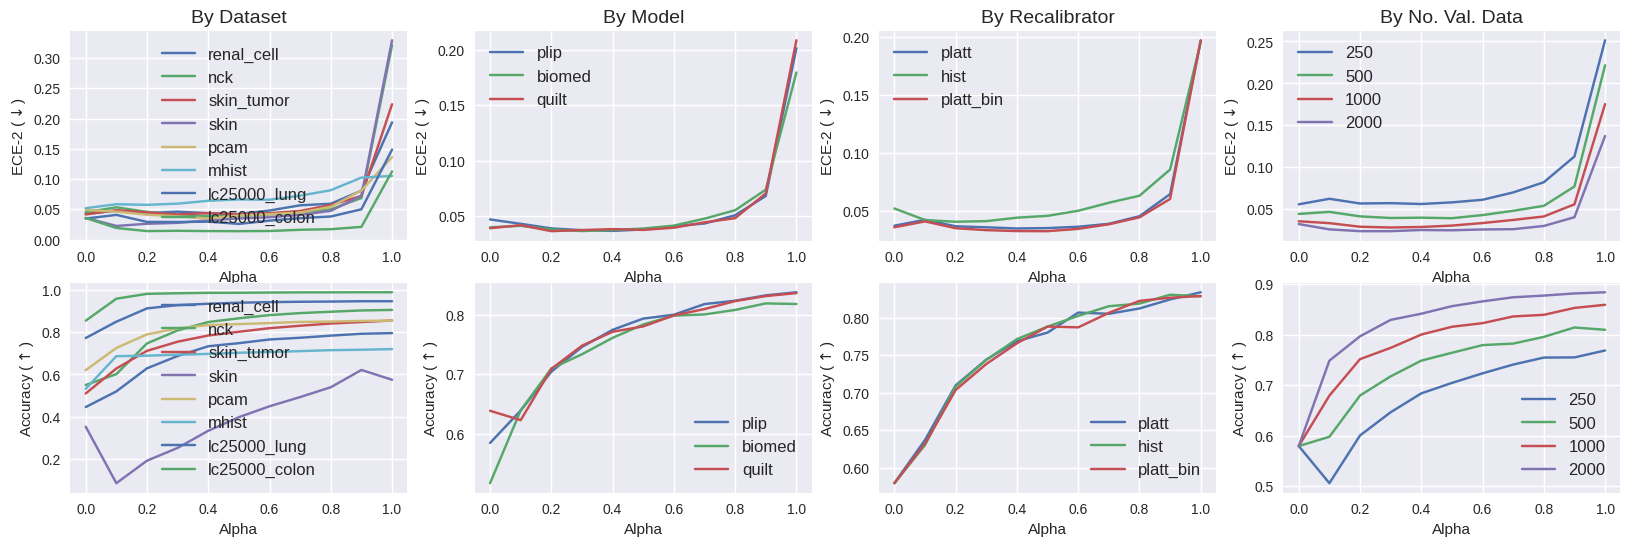

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)

alphas = [i/10 for i in range(11)]
fig, axs = plt.subplots(2, 4)



for dataset in datasets:
    sub_df = final_df[final_df["dataset"] == dataset]
    grouped_cal = sub_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
    axs[0,0].plot(alphas, grouped_cal["ece2"], label=dataset)
    axs[1,0].plot(alphas, grouped_cal["acc"], label=dataset)

for model in models:
    print(model)
    sub_df = final_df[final_df["model"] == model]
    grouped_cal = sub_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
    axs[0,1].plot(alphas, grouped_cal["ece2"], label=model)
    axs[1,1].plot(alphas, grouped_cal["acc"], label=model)

for cal_fn in cal_fns:
    sub_df = final_df[final_df["cal_fn"] == cal_fn]
    grouped_cal = sub_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
    axs[0,2].plot(alphas, grouped_cal["ece2"], label=cal_fn)
    axs[1,2].plot(alphas, grouped_cal["acc"], label=cal_fn)

for n_val in n_vals:
    sub_df = final_df[final_df["n_val"] == n_val]
    grouped_cal = sub_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
    axs[0,3].plot(alphas, grouped_cal["ece2"], label=n_val)
    axs[1,3].plot(alphas, grouped_cal["acc"], label=n_val)


for i in range(2):
    for j in range(4):
        axs[i,j].legend(fontsize=12)

        if i == 0:
            axs[i,j].set_xlabel("Alpha")
            axs[i,j].set_ylabel(r"ECE-2 ($\downarrow$)")
        else:
            axs[i,j].set_xlabel("Alpha")
            axs[i,j].set_ylabel(r"Accuracy ($\uparrow$)")

axs[0,0].set_title("By Dataset", fontsize=14)
axs[0,1].set_title("By Model", fontsize=14)
axs[0,2].set_title("By Recalibrator", fontsize=14)
axs[0,3].set_title("By No. Val. Data", fontsize=14)

# plt.savefig("./plots/few_shot_by_alpha.png", dpi=600, bbox_inches='tight')
plt.show()

<ipython-input-17-a0d37b1fdc43>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Greys')


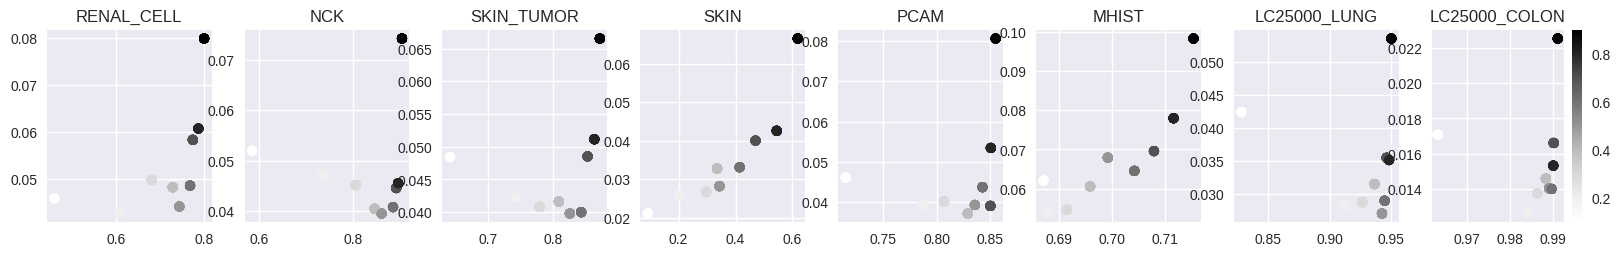

In [ ]:
plt.rcParams["figure.figsize"] = (20,2.5)

cm = plt.cm.get_cmap('Greys')
fig, axs = plt.subplots(1,len(datasets))
for d_idx, dataset in enumerate(datasets):

    axs[d_idx].set_title(dataset.upper())

    for model in ["quilt"]:

        for cal_fn in cal_fns:

            for n_val in n_vals:

                sub_df = final_df[(final_df["dataset"] == dataset) & (final_df["model"] == model)]
                grouped_cal = sub_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
                sc = axs[d_idx].scatter(grouped_cal["acc"].tolist()[1:10], grouped_cal["ece2"].tolist()[1:10], c=alphas[1:10], cmap=cm)



plt.colorbar(sc)
# plt.savefig("./plots/few_shot_acc_vs_ece_2.png", dpi=600, bbox_inches='tight')
plt.show()